In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('sales_train_validation.csv')
dates = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

In [36]:
#let's explore the data
display("sales", sales.head())
display("dates", dates.head())
display("prices", prices.head())

'sales'

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


'dates'

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1


'prices'

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [4]:
#Let's check the missing data
null_prices = prices.isnull().values.any()
null_sales = sales.isnull().values.any()
null_dates = dates.isnull().values.any()
print(null_prices, null_sales, null_dates)

False False True


In [5]:
#so only dates has null value -> let's check the columns with null values
null_dates_clms = dates.isnull().sum()
print(null_dates_clms)

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64


In [6]:
#So there are no missing values except event columns
#let's count the unique events
events = list(dates.event_name_1.unique())
events.remove(events[0])
print("num_events", len(events))

num_events 30


In [7]:
#Let's decide the input shape for our model
#var_1 = days id (0 to 365)
#var_2 = month_id (0-11)
#var_3 = year_id(0-4)
#var_4 = festival(0-31)
#var_5 = state_id (0-we don't know)
#var_6 = store_id(0-we don't know)
#var_7 = product_id(0-we don't know)
#var_8 = product category(0-2)
#var_9 = product_price()

In [63]:
holidays = list(dates.event_name_1.unique())
holidays.pop(0)
states = list(sales.state_id.unique())
stores = list(sales.store_id.unique())
products = list(sales.item_id.unique())
cats = list(sales.cat_id.unique())

num_holidays = len(holidays) #removing the nan value
num_states = len(states) #state id
num_stores = len(stores)
num_items = len(products)
num_cat = len(cats)

print(num_holidays, num_states, num_stores, num_items, num_cat)

30 3 10 3049 3


In [9]:
##We will start with random forest algorithm 
#In first part, we will only use sales data & price data in time series

In [272]:
d_start = 'd_1000'
d_end = 'd_1913'
df = sales.loc[:10, d_start:d_end]
df.insert(0, 'id', sales.loc[:, 'id'])
df.head()

,id,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,d_1007,d_1008,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,0,2,2,0,1,1,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,1,0,8,6,3,2,1,2,2,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,1,1,1,0,0,0,1,2,0,...,2,1,1,0,1,1,2,2,2,4


In [273]:
df['id'] = df.index + 1

In [274]:
df.tail()

,id,d_1000,d_1001,d_1002,d_1003,d_1004,d_1005,d_1006,d_1007,d_1008,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
6,7,1,1,0,1,0,0,0,1,1,...,0,0,0,1,0,1,0,0,1,1
7,8,5,10,3,20,9,3,6,3,8,...,0,0,1,37,3,4,6,3,2,1
8,9,0,0,4,2,0,0,1,0,0,...,0,0,1,1,6,0,0,0,0,0
9,10,0,0,0,0,0,0,0,2,0,...,1,0,0,0,0,0,0,2,0,2
10,11,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


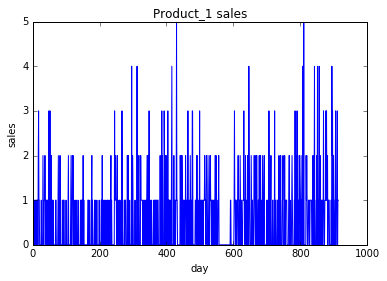

In [275]:
#sales graph for 1st product
plt.plot(np.array(df.iloc[0:1, 1:])[0])
plt.title("Product_1 sales")
plt.xlabel("day")
plt.ylabel("sales")

In [12]:
melt = pd.melt(df, id_vars=['id'], var_name='day', value_name='sales')
melt.head()

,id,day,sales
0,1,d_1000,0
1,2,d_1000,0
2,3,d_1000,0
3,4,d_1000,1
4,5,d_1000,1


In [13]:
#Let's convert d_1 into 1
melt.day = melt.day.str.extract(pat = '(\d+)', expand=False).astype(int)

In [14]:
#display(melt.shape)
melt.head()

,id,day,sales
0,1,1000,0
1,2,1000,0
2,3,1000,0
3,4,1000,1
4,5,1000,1


In [26]:
#Let's add some features
melt_2 = melt.copy()
melt_2['last_1d_sales'] = melt_2.groupby(['id'])['sales'].shift(1)
melt_2['last_1d_diff'] = melt_2.groupby(['id'])['last_1d_sales'].diff(1)
melt_2 = melt_2.dropna()
melt_2.head()

,id,day,sales,last_1d_sales,last_1d_diff
22,1,1002,2,2.0,2.0
23,2,1002,1,0.0,0.0
24,3,1002,0,0.0,0.0
25,4,1002,8,0.0,-1.0
26,5,1002,1,1.0,0.0


In [18]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

In [19]:
#Base line model
base_error = []
for day in range(1880, 1913):
    y_true = melt_2[melt_2['day'] == day]['sales']
    y_pred = melt_2[melt_2['day'] == day]['last_1d_sales']
    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    print("The error in day", day, "is: ", error)
    base_error.append(error)

The error in day 1880 is:  0.7152607628022765
The error in day 1881 is:  0.44984988670940773
The error in day 1882 is:  0.7641191176168801
The error in day 1883 is:  0.7873786212935814
The error in day 1884 is:  0.6228248930999549
The error in day 1885 is:  0.2421222395649405
The error in day 1886 is:  0.7357384229370861
The error in day 1887 is:  0.9509983769442882
The error in day 1888 is:  0.7363975176148102
The error in day 1889 is:  0.5119231195394666
The error in day 1890 is:  0.8150349583568964
The error in day 1891 is:  0.6278180090453233
The error in day 1892 is:  0.743907130642737
The error in day 1893 is:  0.9471996713660463
The error in day 1894 is:  0.6576919272334965
The error in day 1895 is:  0.9074421892233466
The error in day 1896 is:  0.6559298875340689
The error in day 1897 is:  0.7542318207030114
The error in day 1898 is:  0.5639465328739163
The error in day 1899 is:  0.3177542254269308
The error in day 1900 is:  0.5710713168603087
The error in day 1901 is:  0.90548

In [22]:
#random forest model
model_error = []
for day in range(1880, 1913):
    
    #data
    train = melt_2[melt_2['day'] <= day]
    test = melt_2[melt_2['day'] == day]
    x_train, y_train = melt_2[melt_2['day'] <= day].drop('sales', axis=1), melt_2[melt_2['day'] <= day]['sales']
    x_test, y_test = melt_2[melt_2['day'] == day].drop('sales', axis=1), melt_2[melt_2['day'] == day]['sales']
    
    #model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    
    #fit model
    model.fit(x_train, np.log1p(y_train))
    
    #predict
    y_pred = np.expm1(model.predict(x_test))
    y_true = np.array(y_test)

    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    print("The error in day", day, "is: ", error)
    base_error.append(error)

The error in day 1880 is:  0.21053480537102154
The error in day 1881 is:  0.20275129339630973
The error in day 1882 is:  0.20624126384371871
The error in day 1883 is:  0.2976355649195862
The error in day 1884 is:  0.2940758842132633
The error in day 1885 is:  0.2176226419003889
The error in day 1886 is:  0.15641721010601964
The error in day 1887 is:  0.3116419590675743
The error in day 1888 is:  0.21393230766232238
The error in day 1889 is:  0.16040069037287957
The error in day 1890 is:  0.2682877747658381
The error in day 1891 is:  0.27767221325911645
The error in day 1892 is:  0.27438042728591505
The error in day 1893 is:  0.18707282548154336
The error in day 1894 is:  0.21737983892153356
The error in day 1895 is:  0.2812721526125889
The error in day 1896 is:  0.22517532672537036
The error in day 1897 is:  0.11097573055853958
The error in day 1898 is:  0.19969405231652423
The error in day 1899 is:  0.23186047542358243
The error in day 1900 is:  0.13430676148805126
The error in day 19

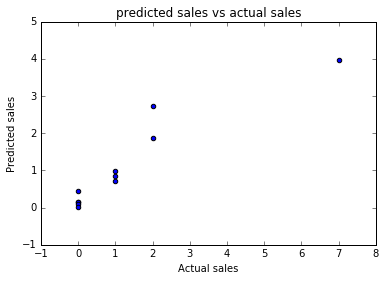

In [24]:
#That is awesome
#Let's plot the scatter plot for last prediction
plt.scatter(y_true, y_pred)
plt.title("predicted sales vs actual sales")
plt.xlabel("Actual sales")
plt.ylabel("Predicted sales")

In [28]:
#Let's add more feature and repeat the process
melt_2['last_2d_sales'] = melt_2.groupby(['id'])['sales'].shift(2)
melt_2['last_2d_diff'] = melt_2.groupby(['id'])['last_2d_sales'].diff(1)
melt_2 = melt_2.dropna()

#random forest model
model_error = []
for day in range(1880, 1913):
    
    #data
    train = melt_2[melt_2['day'] <= day]
    test = melt_2[melt_2['day'] == day]
    x_train, y_train = melt_2[melt_2['day'] <= day].drop('sales', axis=1), melt_2[melt_2['day'] <= day]['sales']
    x_test, y_test = melt_2[melt_2['day'] == day].drop('sales', axis=1), melt_2[melt_2['day'] == day]['sales']
    
    #model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    
    #fit model
    model.fit(x_train, np.log1p(y_train))
    
    #predict
    y_pred = np.expm1(model.predict(x_test))
    y_true = np.array(y_test)

    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    print("The error in day", day, "is: ", error)
    base_error.append(error)

The error in day 1880 is:  0.17996370558659178
The error in day 1881 is:  0.18182793551019777
The error in day 1882 is:  0.22006461150664033
The error in day 1883 is:  0.2621508476824019
The error in day 1884 is:  0.2652076526160598
The error in day 1885 is:  0.22838656648735117
The error in day 1886 is:  0.16152669828640703
The error in day 1887 is:  0.27268121046680244
The error in day 1888 is:  0.18841276652591576
The error in day 1889 is:  0.17024699007236857
The error in day 1890 is:  0.2752608798269468
The error in day 1891 is:  0.23243094500717967
The error in day 1892 is:  0.3207305137749456
The error in day 1893 is:  0.17222543339260424
The error in day 1894 is:  0.24888682717052502
The error in day 1895 is:  0.2573623685151228
The error in day 1896 is:  0.22249873844818135
The error in day 1897 is:  0.138994188581446
The error in day 1898 is:  0.19885969801279002
The error in day 1899 is:  0.20969946440506051
The error in day 1900 is:  0.11412955842332964
The error in day 190

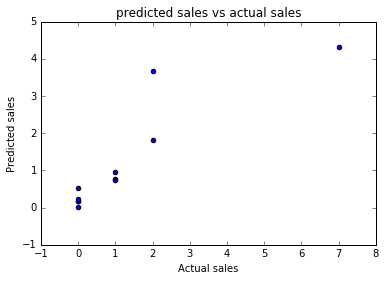

In [29]:
#That is awesome
#Let's plot the scatter plot for last prediction
plt.scatter(y_true, y_pred)
plt.title("predicted sales vs actual sales")
plt.xlabel("Actual sales")
plt.ylabel("Predicted sales")

In [166]:
#Let's take the prices and festival info into account

In [217]:
##Adding event data into training data
dates_data = dates[996:1909] #number chosen as per the taken range
days = dates_data[dates_data['event_name_1'].isin(holidays)] 
holiday_list = list(days['d'])
event_name_list = list(days['event_name_1']) 
day_list = list(dates_data['d'])

index = 0
item_taken = 11
event = [[0] * item_taken] #because 1st day is missing
for day in day_list:
    if day in holiday_list:
        hol_index = holiday_list.index(day)
        event_id = holidays.index(event_name_list[hol_index])
        temp_list = [event_id] * item_taken
    else:
        temp_list = [0] * item_taken
        
    event.append(temp_list)
    index += 1
flatten_event = [i for li in event for i in li]

In [218]:
##Adding the price data into training data
start_wmyrwk = 11338
temp_data = prices.groupby('wm_yr_wk')

price_list = [[0] * item_taken]
week = start_wmyrwk
count = 0
for day in day_list:
    count += 1
    if count % 7 == 1:
        try:
            week_data = list(temp_data.get_group(week)[0:11]['sell_price'])
            week += 1
        except:
            week += 1
            #print("data for week", week, "doen't exist")
    price_list.append(week_data)
    
flatten_price = [i for li in price_list for i in li]

In [219]:
data = melt.copy()
data['event'] = flatten_event
data['price'] = flatten_price

In [268]:
melt_2 = data.copy()
melt_2['last_1d_sales'] = melt_2.groupby(['id'])['sales'].shift(1)
melt_2['last_1d_diff'] = melt_2.groupby(['id'])['last_1d_sales'].diff(1)
melt_2 = melt_2.dropna()

melt_2['last_2d_sales'] = melt_2.groupby(['id'])['sales'].shift(2)
melt_2['last_2d_diff'] = melt_2.groupby(['id'])['last_2d_sales'].diff(1)
melt_2 = melt_2.dropna()

#random forest model
model_error = []
for day in range(1880, 1913):
    
    #data
    train = melt_2[melt_2['day'] <= day]
    test = melt_2[melt_2['day'] == day]
    x_train, y_train = melt_2[melt_2['day'] <= day].drop('sales', axis=1), melt_2[melt_2['day'] <= day]['sales']
    x_test, y_test = melt_2[melt_2['day'] == day].drop('sales', axis=1), melt_2[melt_2['day'] == day]['sales']
    
    #model
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    
    #fit model
    model.fit(x_train, np.log1p(y_train))
    
    #predict
    y_pred = np.expm1(model.predict(x_test))
    y_true = np.array(y_test)

    error = np.sqrt(mean_squared_log_error(y_true, y_pred))
    print("The error in day", day, "is: ", error)
    model_error.append(error)

The error in day 1880 is:  0.15271895138519592
The error in day 1881 is:  0.1713355652779115
The error in day 1882 is:  0.19592602364096723
The error in day 1883 is:  0.26385379290773303
The error in day 1884 is:  0.27748852783315336
The error in day 1885 is:  0.24113160455857155
The error in day 1886 is:  0.15042116086280194
The error in day 1887 is:  0.2995666379303941
The error in day 1888 is:  0.1888383482721442
The error in day 1889 is:  0.16115053289804435
The error in day 1890 is:  0.2603532794272896
The error in day 1891 is:  0.22753897764203287
The error in day 1892 is:  0.32467408542663717
The error in day 1893 is:  0.17551960571864822
The error in day 1894 is:  0.2395161533151598
The error in day 1895 is:  0.24291223127461783
The error in day 1896 is:  0.2177110466451069
The error in day 1897 is:  0.13334425836817007
The error in day 1898 is:  0.20438106540585388
The error in day 1899 is:  0.21093129237537628
The error in day 1900 is:  0.1175930955216627
The error in day 190

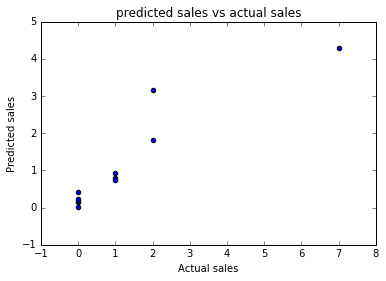

In [247]:
#As we can see there was around 0.01-0.02 decrease after including price
#Let's plot the scatter plot for last prediction
plt.scatter(y_true, y_pred)
plt.title("predicted sales vs actual sales")
plt.xlabel("Actual sales")
plt.ylabel("Predicted sales")

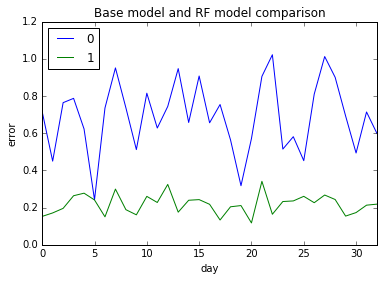

In [269]:
#error plots
df_error = pd.DataFrame(list(zip(base_error, model_error)))
df_error.plot()
plt.title("Base model and RF model comparison")
plt.xlabel("day")
plt.ylabel("error")

In [270]:
# As we have seen, model is not performing well for higher values of sales
# We can investigate more about this problem
# My laptop doesn't support CUDA so I am not training the model for full data. 
# Model can be improved using more features, boosting, bagging and other improved random forest algorithms 